In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
import numpy as np
import os
import pandas as pd
import torch
import config
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

DATASET_PATH = "/home/pk/Downloads/PASCAL_VOC/"


In [3]:
def iou(boxes_prediction, boxes_target):
    """
    Parameters:
        boxes_prediction (tensor): width and height of the prediction bboxes
        boxes_target (tensor): width and height of the target bboxes
    Returns:
        tensor: Intersection over Union of the corresponding bboxes
    """
    intersection = torch.min(boxes_prediction[..., 0], boxes_target[..., 0]) * torch.min(
                        boxes_prediction[..., 1], boxes_target[..., 1])
    
    union = (
        boxes_prediction[..., 0] * boxes_prediction[..., 1] + boxes_target[..., 0] * boxes_target[..., 1] - intersection
    )
    return intersection / union
    

In [4]:
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] 

In [5]:
class YOLODataset(Dataset):
    
    def __init__(self, 
                 csv_file,
                 img_dir,
                 label_dir,
                 anchors,
                image_size=416,
                S=[13, 26, 52],
                C=20,
                transform=None):
        
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.Tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))
        
        # apply augmentations with albumentations
        if self.transform:
            augmentations = self.transform(image=image, bboxes = bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
            
        # building the target below
        # 6 targets are object_score, X, Y, H, W, class_number
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3 # each scale should have one anchor
            for anchor_idx in anchor_indices:
                # get the hight
                scale_idx = anchor_idx  // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                # get the center of the coordinates at that scale level
                i, j = int(S * y), int(S * x) # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                #print(i, j)
                if not anchor_taken and not has_anchor[scale_idx]:
                    # marking there is an object at that scale index
                    # by setting object score to 1
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    
                    x_cell, y_cell = S * x -j, S * y - i
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )
                    
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True
                    #print(anchor_on_scale)
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore prediction
        
        return image, tuple(targets)

def __init__(self, 
                 csv_file,
                 img_dir,
                 label_dir,
                 anchors,
                image_size=416,
                S=[13, 26, 52],
                C=20,

In [6]:
csv_file = DATASET_PATH + 'train.csv'
img_dir = DATASET_PATH + 'images/'
label_dir = DATASET_PATH + 'labels/'
anchors = ANCHORS
train_dataset = YOLODataset(csv_file, img_dir, label_dir, anchors)

In [7]:
img, target = train_dataset[0]

<ipython-input-5-b794cd9284e5>:50: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  scale_idx = anchor_idx  // self.num_anchors_per_scale


In [8]:
img.shape

(333, 500, 3)

In [9]:
target[0].shape, target[1].shape, target[2].shape

(torch.Size([3, 13, 13, 6]),
 torch.Size([3, 26, 26, 6]),
 torch.Size([3, 52, 52, 6]))

#### Loss functions

##### No object loss

In [10]:
# just plain bce loss on the no-object probabilites

##### Object loss

In [11]:
import random
import torch.nn as nn

class YoloLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        
        # constants for weighting differenet losses differently
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10
        
    def forward(self, predictions, target, anchors):
        
        obj = target[..., 0] == 1
        no_obj == target[..., 0] == 0
        
        # object score loss for no objects
        no_object_loss = self.bce(
            (predictions[..., 0:1][no_obj]), (target[..., 0:1][no_obj])
        )
        
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), 
                               torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        # object score loss when there are object, and object probability is the iou
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))
        
        # x, y, h, w mse loss
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])
        
        # class loss
        class_loss = self.entropy(
            (predictions[..., 5][obj]), (target[..., 5][obj].long()),
        )
        
        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )
        

#### Transformations

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [13]:
IMAGE_SIZE = 416
scale=1.1
border_constant = cv2.BORDER_CONSTANT
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=border_constant,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=border_constant
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)

/home/pk/anaconda3/envs/simulator/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:337: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


In [14]:
from transformations import YoloTrainTransformations

In [18]:
csv_file = DATASET_PATH + 'train.csv'
img_dir = DATASET_PATH + 'images/'
label_dir = DATASET_PATH + 'labels/'
anchors = ANCHORS

train_dataset_transformed = YOLODataset(csv_file, img_dir, label_dir, 
                                        anchors,
                                       transform=YoloTrainTransformations())

In [41]:
img, targets = train_dataset_transformed[2126]

<ipython-input-5-b794cd9284e5>:50: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  scale_idx = anchor_idx  // self.num_anchors_per_scale


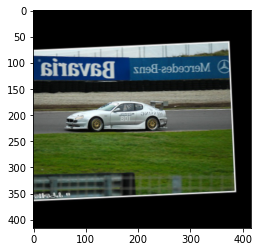

In [42]:
plt.imshow(img.permute(1, 2,0))